## Imports and preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/BatchMultivalidConformal-main/src')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install folktables
!pip install optax

import splitConformalPrediction
from recursiveLeastSquares import *
import folktables
from CalibrationScorers.customResidualCalibrationScorer import customResidualCalibrationScorer
from MultivalidAlgorithms.MultivalidCoverage import multivalid_coverage, eval_fn
from DatasetGeneration.DivisibleDataset import divisible_dataset
from MultivalidAlgorithms.GroupCoverage import group_coverage

In [11]:
def produce_group(feat_index, feat_value):
    '''
        Input:
            - feat_index: index of desired input feature
            - feat_value: desired value of that feature
        Output:
            - f - function which defines a group; f(x) returns True
                  iff x[feat_index] == feat_value and returns False otherwise.
    '''
    def f(x):
      return (x[feat_index] == feat_value)

    return f

groups = list()
num_groups = 0
for j in range(1,11):
    curr_group_fun = produce_group(0, j)
    groups.append(curr_group_fun)
    num_groups += 1


def all_points(x):
    return True

basic_group = [all_points]
num_groups_basic = 1


group_fn =(lambda x: [group(x) for group in groups])

In [3]:
with open('S01R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data1 = np.insert(processed_data, 0, 1, axis=1)

with open('S02R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data2 = np.insert(processed_data, 0, 2, axis=1)

with open('S03R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data3 = np.insert(processed_data, 0, 3, axis=1)

with open('S04R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data4 = np.insert(processed_data, 0, 4, axis=1)

with open('S05R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data5 = np.insert(processed_data, 0, 5, axis=1)

with open('S06R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data6 = np.insert(processed_data, 0, 6, axis=1)

with open('S07R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data7 = np.insert(processed_data, 0, 7, axis=1)

with open('S08R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data8 = np.insert(processed_data, 0, 8, axis=1)

with open('S09R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data9 = np.insert(processed_data, 0, 9, axis=1)

with open('S10R01.txt', 'r') as file:
    data = file.readlines()

processed_data = [list(map(int, line.split())) for line in data]
data10 = np.insert(processed_data, 0, 10, axis=1)

In [4]:
data = np.vstack([data1,data2,data3,data4,data5,data6,data7,data8,data9,data10])
xs = data[:,:-1]
ys = data[:,-1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, train_size = 0.8, test_size=0.2, shuffle = True)
training_size, numFeatures = np.shape(X_train)

# Separate training data into training (for point-predictor) and calibration
print(np.shape(X_train))
training_set_size = len(y_train)
calibration_set_size = int(0.25 * training_set_size)
new_train_set_size = len(y_train) - calibration_set_size
x_train_final = X_train[ : new_train_set_size]
x_calib = X_train[new_train_set_size : ]
y_train_final = y_train[ : new_train_set_size]
y_calib = y_train[new_train_set_size : ]
print(new_train_set_size)
print(calibration_set_size)
print(len(y_test))
print(len(y_train))

(1177436, 11)
883077
294359
294360
1177436


## Synthetic Experiment with groups - Comparing conformal prediction methods: Single trial

##### Set all parameters for a single trial

In [6]:
# Parameters for our uncertainty quantifier(s)
tau = 0.9
delta = 1 - tau
num_grid = 300

##### Taking census data and splitting into train (0.6), calibration (0.2) and test (0.2) data.

In [7]:
# Train point-predictor using x_train_final and y_train_final
myRLS = RLS(numFeatures, 1.0, 1)
for i in range(new_train_set_size):
    myRLS.add_obs(x_train_final[i], y_train_final[i])

In [8]:
# Convert y_calib values into threshold values in order to train for conformal prediction
from CalibrationScorers.customResidualCalibrationScorer import customResidualCalibrationScorer
mult_factor = 800000 # Set to value which ensures majority of threshold values are within [0, 1]
residualCalibrationScorer = customResidualCalibrationScorer(mult_factor)
residualCalibrationScorer.update(myRLS.predict)

# These are the scores which we want to achieve threshold-calibration with respect to
w_calib = np.array([residualCalibrationScorer.calc_score(x_calib[i], y_calib[i]) for i in range(calibration_set_size)])

# Checking if values in w_calib are outside desired range.
for val in w_calib:
    if val < 0 or val > 1:
        print(val)
print(min(w_calib), max(w_calib))

w_test = np.array([residualCalibrationScorer.calc_score(X_test[i], y_test[i]) for i in range(len(y_test))])

3.4613466778909975e-12 1.4349565026752816e-05


##### Run each of the 4 methods using x_calib and w_calib to train conformal predictors

In [13]:
# Iterative algorithm for multivalidity

patches = multivalid_coverage(tau=tau, x_train=x_calib, y_train=w_calib, num_grid=num_grid, group_fn=group_fn)
multivalid_model = lambda x: eval_fn(x, patches=patches, num_grid=num_grid, group_fn=group_fn)

Max violation in round 0  :  393.0299999999998


In [16]:
# One-shot algorithm for group coverage
group_accurate_model, opt_theta = group_coverage(tau=tau, x_train=x_calib, y_train=w_calib, num_groups=num_groups, group_fn=group_fn)


Optimal theta found: [0.00180562 0.00270127 0.00627424 0.00475436 0.00439322 0.00565517
 0.00425282 0.0044276  0.00286593 0.00435514]


In [17]:
# Training naive conformal predictor and conservative group-wise conformal predictor
marginalConformalPredictor = splitConformalPrediction.splitConformal(1, basic_group, delta)
groupConformalPredictor = splitConformalPrediction.splitConformal(num_groups, groups, delta)
group_cov_marginal = np.zeros(num_groups)
group_num_marginal = np.zeros(num_groups)
group_cov_group = np.zeros(num_groups)
group_num_group = np.zeros(num_groups)
group_pred_set_size_marginal = np.zeros(num_groups)
group_pred_set_size_group = np.zeros(num_groups)

for i, curr_x in enumerate(x_calib):
    curr_y = y_calib[i]
    marginalConformalPredictor.update_calibration_data(curr_x, curr_y)
    groupConformalPredictor.update_calibration_data(curr_x, curr_y)

In [19]:
# Running naive conformal predictor and conservative group-wise conformal predictor on test-data

grid_size = 2 * num_grid
marginal_sizes = np.zeros((num_groups, grid_size))
marginal_coverage_total = np.zeros((num_groups, grid_size))
marginal_averaged_coverage = np.zeros((num_groups, grid_size))
conformal_sizes = np.zeros((num_groups, grid_size))
conformal_coverage_total = np.zeros((num_groups, grid_size))
conformal_averaged_coverage = np.zeros((num_groups, grid_size))

for i, curr_x in enumerate(X_test):
    curr_y = y_test[i]
    curr_w = w_test[i]
    w_marginal_conformal = marginalConformalPredictor.select_best_width(residualCalibrationScorer, curr_x)
    w_group_conformal = groupConformalPredictor.select_best_width(residualCalibrationScorer, curr_x)
    pred_index1 = int(w_marginal_conformal * grid_size)
    pred_index2 = int(w_group_conformal * grid_size)
    for j in range(num_groups):
        if groups[j](curr_x) == True:
            group_num_marginal[j] += 1
            group_num_group[j] += 1
            group_cov_marginal[j] += int(w_marginal_conformal > curr_w)
            group_cov_group[j] += int(w_group_conformal > curr_w)
            group_pred_set_size_marginal[j] += 2 * mult_factor * w_marginal_conformal
            group_pred_set_size_group[j] += 2 * mult_factor * w_group_conformal
            marginal_sizes[j][pred_index1] += 1
            marginal_coverage_total[j][pred_index1] += int(w_marginal_conformal > w_test[i])
            conformal_sizes[j][pred_index2] += 1
            conformal_coverage_total[j][pred_index2] += int(w_group_conformal > w_test[i])

marginal_conformal_coverage = [group_cov_marginal[j]/group_num_marginal[j] for j in range(num_groups)]
group_conformal_coverage = [group_cov_group[j]/group_num_group[j] for j in range(num_groups)]
marginal_conformal_size = [group_pred_set_size_marginal[j]/group_num_marginal[j] for j in range(num_groups)]
group_conformal_size = [group_pred_set_size_group[j]/group_num_group[j] for j in range(num_groups)]

## Plotting Results

##### Plot single method results for either BatchGCP or BatchMVP

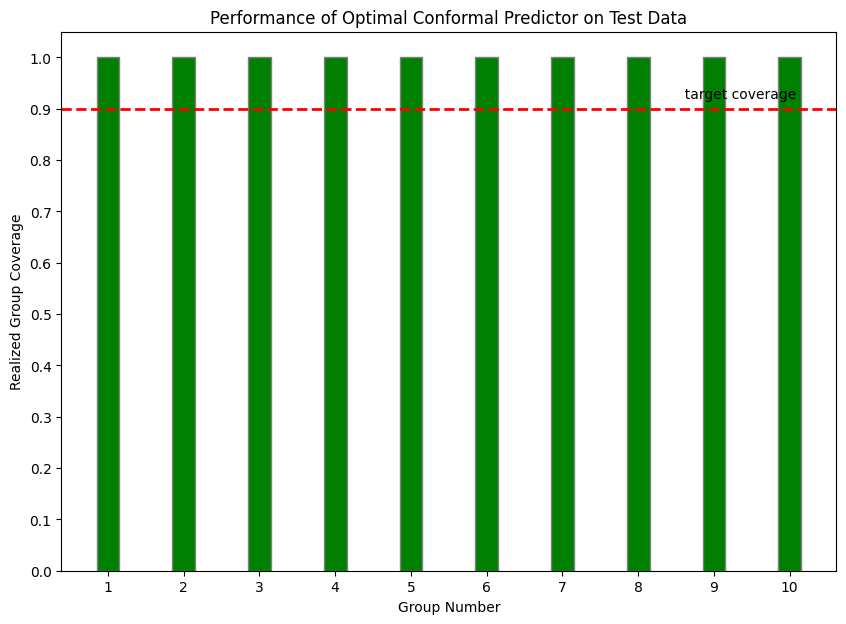

Coverage on group 1 : 1.0
Coverage on group 2 : 1.0
Coverage on group 3 : 1.0
Coverage on group 4 : 1.0
Coverage on group 5 : 1.0
Coverage on group 6 : 1.0
Coverage on group 7 : 1.0
Coverage on group 8 : 1.0
Coverage on group 9 : 1.0
Coverage on group 10 : 1.0


In [14]:
from utils.MultivalidPlotting import plot_group_coverage, plot_all_group_coverage

# To plot single method results - set model param to group_accurate_model, or to multivalid_model
plot_group_coverage(model=multivalid_model, tau=tau, x_test=X_test, y_test=w_test, num_groups=num_groups, group_fn=group_fn, multivalid=False, verbose=True)

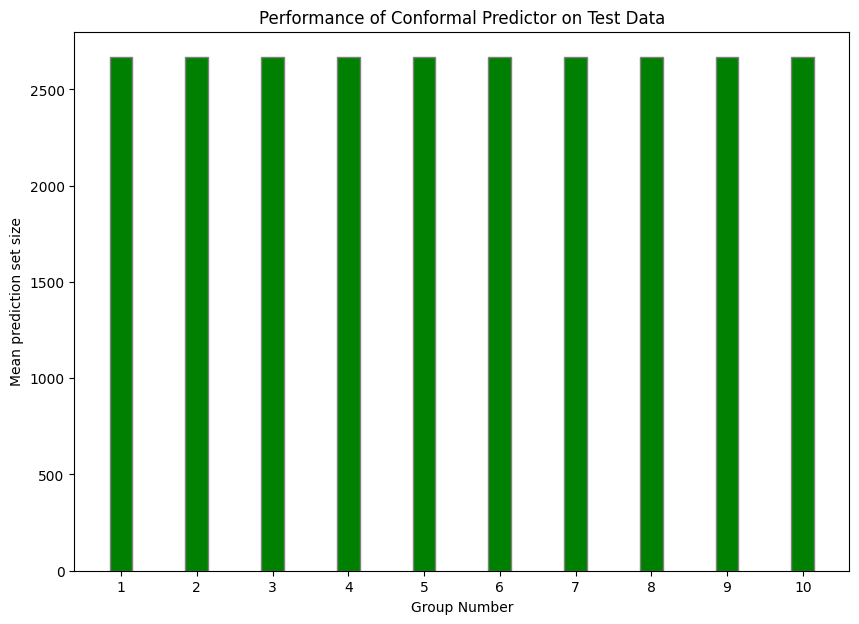

Average prediction set size on group 1 : 2666.666666666698
Average prediction set size on group 2 : 2666.6666666667834
Average prediction set size on group 3 : 2666.66666666643
Average prediction set size on group 4 : 2666.666666667812
Average prediction set size on group 5 : 2666.666666665885
Average prediction set size on group 6 : 2666.6666666673755
Average prediction set size on group 7 : 2666.666666665753
Average prediction set size on group 8 : 2666.6666666660967
Average prediction set size on group 9 : 2666.6666666672904
Average prediction set size on group 10 : 2666.666666667759


In [20]:
from utils.MultivalidPlotting import plot_pred_set_size, plot_all_pred_set_sizes

plot_pred_set_size(model=multivalid_model, tau=tau, x_test=X_test, y_test=w_test, num_groups=num_groups, group_fn=group_fn, mult_width = mult_factor, multivalid=False, verbose=True)

##### Plot all method results against each other

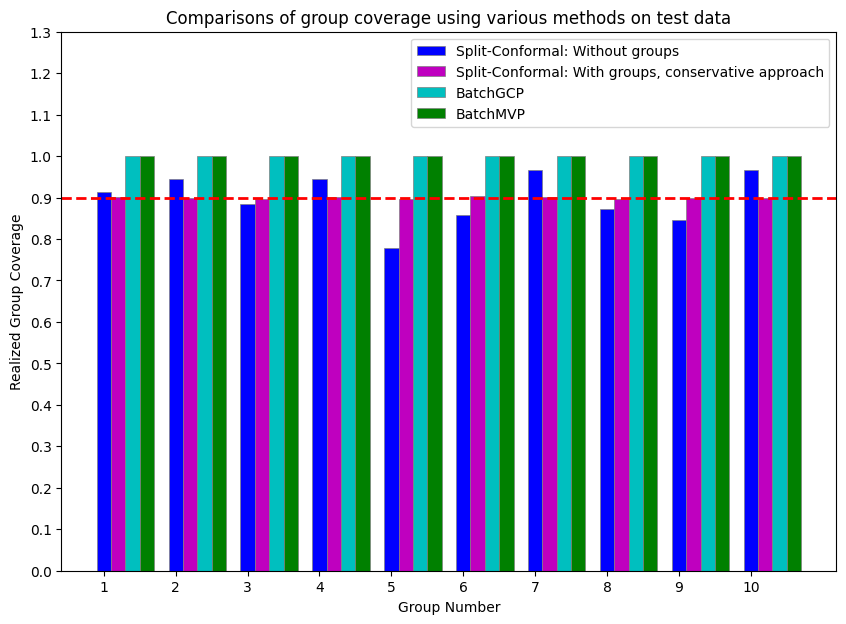

In [21]:
# Plotting group-wise coverage

plot_all_group_coverage(group_accurate_model, multivalid_model, tau, X_test, w_test, num_groups, group_fn, marginal_conformal_coverage, group_conformal_coverage, multivalid=False, bar_width = 0.2)

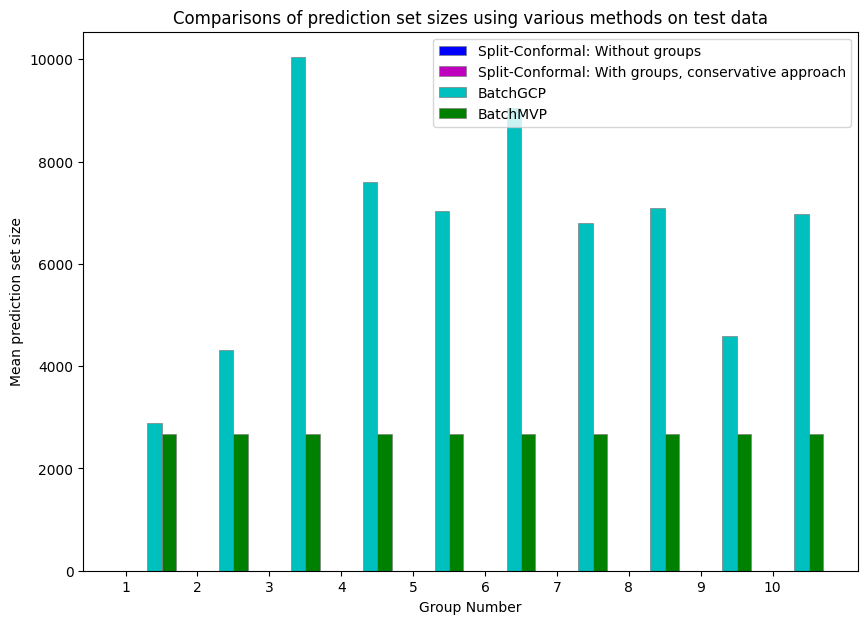

In [25]:
# Plotting group-wise prediction set size

plot_all_pred_set_sizes(group_accurate_model, multivalid_model, tau, X_test, w_test, num_groups, group_fn, mult_factor, marginal_conformal_size, group_conformal_size, multivalid=False, bar_width=0.2)

##### Scatterplot of group-threshold pair coverage against size

In [23]:
grid_size = 2 * num_grid
multivalid_sizes = np.zeros((num_groups, grid_size))
multivalid_coverage_total = np.zeros((num_groups, grid_size))
group_sizes = np.zeros((num_groups, grid_size))
group_coverage_total = np.zeros((num_groups, grid_size))

group_accurate_multivalid_sizes = np.zeros(num_groups)
group_accurate_multivalid_coverage = np.zeros(num_groups)
group_accurate_multivalid_pred_set_size = np.zeros(num_groups)
group_accurate_group_sizes = np.zeros(num_groups)
group_accurate_group_coverage = np.zeros(num_groups)
group_accurate_group_pred_set_size = np.zeros(num_groups)

for i, test_val in enumerate(X_test):
    pred1 = multivalid_model(test_val)
    pred_index1 = int(pred1 * grid_size)
    pred2 = group_accurate_model(test_val)
    pred_index2 = int(pred2 * grid_size)
    for k in range(num_groups):
        if group_fn(test_val)[k]:
            multivalid_sizes[k][pred_index1] += 1
            multivalid_coverage_total[k][pred_index1] += int(pred1 > w_test[i])
            group_sizes[k][pred_index2] += 1
            group_coverage_total[k][pred_index2] += int(pred2 > w_test[i])
            group_accurate_multivalid_sizes[k] += 1
            group_accurate_multivalid_coverage[k] += int(pred1 > w_test[i])
            group_accurate_multivalid_pred_set_size[k] += (2 * pred1 * mult_factor)
            group_accurate_group_sizes[k] += 1
            group_accurate_group_coverage[k] += int(pred2 > w_test[i])
            group_accurate_group_pred_set_size[k] += (2 * pred2 * mult_factor)

final_group_coverage = [group_accurate_group_coverage[j]/group_accurate_group_sizes[j] for j in range(num_groups)]
final_multivalid_coverage = [group_accurate_multivalid_coverage[j]/group_accurate_multivalid_sizes[j] for j in range(num_groups)]
final_group_pred_set_size = [group_accurate_group_pred_set_size[j]/group_accurate_group_sizes[j] for j in range(num_groups)]
final_multivalid_pred_set_size = [group_accurate_multivalid_pred_set_size[j]/group_accurate_multivalid_sizes[j] for j in range(num_groups)]

x_scatter1 = list()
y_scatter1 = list()
x_scatter2 = list()
y_scatter2 = list()
x_scatter3 = list()
y_scatter3 = list()
x_scatter4 = list()
y_scatter4 = list()

for k in range(num_groups):
    for j in range(grid_size):
        if multivalid_sizes[k][j] > 0:
            x_scatter1.append(multivalid_sizes[k][j])
            y_scatter1.append(multivalid_coverage_total[k][j] / multivalid_sizes[k][j])
        if group_sizes[k][j] > 0:
            x_scatter2.append(group_sizes[k][j])
            y_scatter2.append(group_coverage_total[k][j] / group_sizes[k][j])
        if marginal_sizes[k][j] > 0:
            x_scatter3.append(marginal_sizes[k][j])
            y_scatter3.append(marginal_coverage_total[k][j] / marginal_sizes[k][j])
        if conformal_sizes[k][j] > 0:
            x_scatter4.append(conformal_sizes[k][j])
            y_scatter4.append(conformal_coverage_total[k][j] / conformal_sizes[k][j])

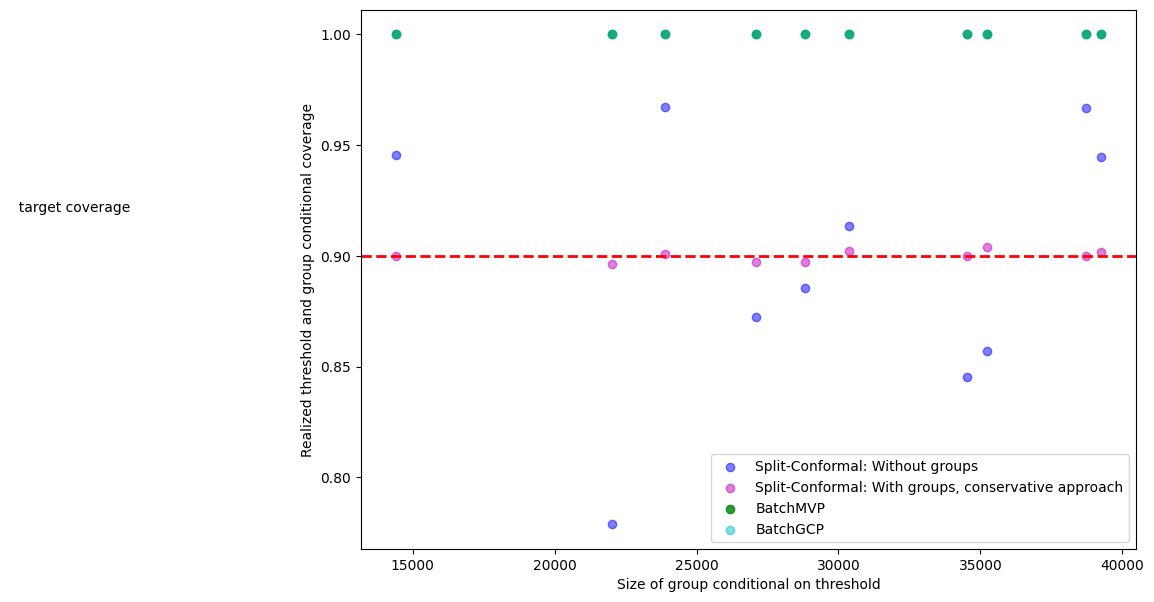

In [24]:
# Plot scatter
plt.figure(figsize=(10, 7))
plt.scatter(x_scatter3, y_scatter3, color='b', alpha = 0.5, label = 'Split-Conformal: Without groups')
plt.scatter(x_scatter4, y_scatter4, color='m', alpha = 0.5, label = 'Split-Conformal: With groups, conservative approach')
plt.scatter(x_scatter1, y_scatter1, color='g', alpha = 0.8, label = 'BatchMVP')
plt.scatter(x_scatter2, y_scatter2, color='c', alpha = 0.5, label = 'BatchGCP')
plt.axhline(y=tau, c='r', linestyle='--', linewidth=2)
plt.text(810, tau + 0.02, '  target coverage')
plt.xlabel('Size of group conditional on threshold')
plt.ylabel('Realized threshold and group conditional coverage')
plt.legend()
plt.show()